# Backbone congelada y descongelada

## Backbone y head

Antes de nada hay que explicar qué son el backbone y el head de una red neuronal convolucional. Como ya vimos, una arquitectura de red convolucional se compone de un montón de capas convolucionales, pooling y funciones no lineales repetidas, y por último una o varias capas de tipo fully connected. Por tanto se suele llamar backbone a la parte donde está todo el conjunto de capas convolucionales, y head a la capa o capas fully connected

![CNN](Imagenes/CNN.jpeg)

En la anterior imagen, el *feature learning*, o extractor de características, corresponde al *backbone* y la parte de *classification* corresponde a la head

Esta separación de la red se hace porque el backbone es el extractor de características (feature extractor), es decir, es capaz de sacar todas las características importantes de la imagen, y luego una head es la que es capaz de realizar por ejemplo la clasififcación analizando esas características y metiéndolas en una pequeña red fully connected.

Por tanto, una misma backbone puede ser usada para distintas tareas solo cambiando la head

## Congelar el backbone

Como hemos dicho, una misma backbone puede servir para distintas tareas solo poniendo distintas heads. Pero qué pasa si no tenemos heads para una nueva tarea, tendremos que crear una nueva y entrenarla.

Sin embargo cuando entrenamos una red, la entrenamos entera, tanto el backbone como la head. Pero entrenar el backbone no tiene sentido, ya que ya sabe extraer las características importantes de las imágenes. Por lo que reentrenarlo, solo puede llevar a sobreentrenamientos, y tardar mucho más (ya que al haber más capas, hay más cálculos) en cada epoch

Puede que tengamos un problema muy parecido a Imagenet, por ejemplo, queremos una red que sepa distinguir entre perros y gatos. Las redes preentrenadas para Imagenet ya saben clasificar perros y gatos, es decir, saben sacar las características de estos en una imagen, por lo que no tiene sentido reentrenarla

Para solucionar esto, lo que se hace es congelar el backbone. Así, en el ejemplo de gatos y perros, vamos a tener una backbone que ya sabe sacar las características, pero que al entrenar la red no se va a modificar. Además le vamos a añadir una nueva head, que solo clasifica entre perros y gatos, y esta sí que va a hacer falta entrenarla

## Como congelar en Pytorch

En Pytorch, cada parámetro de la red tiene un atributo llamado `data` y otro llamado `requires_grad`

In [4]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)
for i, param in enumerate(model.parameters()):
    print(f"parameter {i}: type(param.data): {type(param.data)}, param.requires_grad: {param.requires_grad}")

parameter 0: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 1: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 2: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 3: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 4: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 5: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 6: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 7: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 8: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 9: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 10: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 11: type(param.data): <class 'torch.Tensor'>, param.requires_grad): True
parameter 12: 

Por lo que para congelar el backbone podemos congelar toda la red, menos la última capa fully connected

In [7]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
for i, param in enumerate(model.parameters()):
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

Al hacer esto, Pytorch no calculará los gradientes en el backbone, solo en la capa fully connected, por lo que solo actualizará los pesos de la capa fully connected

Vamos a volver a ver los parámetros de la red

In [8]:
for i, param in enumerate(model.parameters()):
    print(f"parameter {i}: type(param.data): {type(param.data)}, param.requires_grad: {param.requires_grad}")

parameter 0: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 1: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 2: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 3: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 4: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 5: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 6: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 7: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 8: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 9: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 10: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 11: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 12: 

Vemos que todos `param.requires_grad` son `False` menos los dos últimos

## Ejemplo de entrenamiento con backbone congelada

Vamos a ver un ejemplo de entrenamiento de una red con el backbone congelado, para reconocer entre gatos y perros, para ello usaremos el dataset [cats vs dogs](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset). Lo descargo desde kaggle y lo guardo en `data`

### EDA

Vemos el archivo que se ha descargado

In [9]:
!ls data

archive.zip  intel  MNIST


Lo descomprimimos

In [10]:
!unzip -q data/archive.zip -d data/cats_vs_dogs

Vemos qué tenemos ahora

In [11]:
!ls data/cats_vs_dogs

'MSR-LA - 3467.docx'   PetImages  'readme[1].txt'


Aprovechamos y borramos el *.zip* para ahorrar espacio

In [12]:
!rm data/archive.zip

Vemos qué hay dentro de `PetImages`

In [13]:
!ls data/cats_vs_dogs/PetImages

Cat  Dog


Hay una carpeta con fotos de gatos y otra con fotos de perros

In [15]:
!ls data/cats_vs_dogs/PetImages/Cat | head -5

0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
ls: write error: Broken pipe


In [16]:
!ls data/cats_vs_dogs/PetImages/Dog | head -5

0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
ls: write error: Broken pipe


### Dataframe

A la hora de hacer el cuaderno vi que algunas imágenes estaban mal, así que vamos a buscarlas y eliminarlas

Buscamos primero en la carpeta de gatos

In [17]:
import os
import pandas as pd
import cv2

df_cats = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Cat', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Cat')]})
df_cats['label'] = 0
df_cats['type'] = df_cats['path'].apply(lambda x: type(cv2.imread(x)))

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


In [18]:
df_cats.head()

,path,label,type
0,data/cats_vs_dogs/PetImages/Cat/8115.jpg,0,<class 'numpy.ndarray'>
1,data/cats_vs_dogs/PetImages/Cat/6066.jpg,0,<class 'numpy.ndarray'>
2,data/cats_vs_dogs/PetImages/Cat/1140.jpg,0,<class 'numpy.ndarray'>
3,data/cats_vs_dogs/PetImages/Cat/6135.jpg,0,<class 'numpy.ndarray'>
4,data/cats_vs_dogs/PetImages/Cat/5688.jpg,0,<class 'numpy.ndarray'>


Vemos los posiles valores de la columna type

In [19]:
df_cats.type.unique()

array([<class 'numpy.ndarray'>, <class 'NoneType'>], dtype=object)

Como se puede ver hay arrays de numpy y `None`s. Por lo que vamos a borrar los últimos

In [20]:
df_cats = df_cats[df_cats.type != type(None)]
df_cats.type.unique()

array([<class 'numpy.ndarray'>], dtype=object)

Hacemos lo mismo con los perros

In [21]:
df_dogs = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Dog', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Dog')]})
df_dogs['label'] = 1
df_dogs['type'] = df_dogs['path'].apply(lambda x: type(cv2.imread(x)))
df_dogs.type.unique()

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


array([<class 'numpy.ndarray'>, <class 'NoneType'>], dtype=object)

In [22]:
df_dogs = df_dogs[df_dogs.type != type(None)]
df_dogs.type.unique()

array([<class 'numpy.ndarray'>], dtype=object)

Creamos un solo dataframe con la unión de los dos

In [23]:
df = pd.concat([df_cats, df_dogs], axis=0).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)   # suffle df
df['height'] = df['path'].apply(lambda x: cv2.imread(x).shape[0])
df['width'] = df['path'].apply(lambda x: cv2.imread(x).shape[1])
df.head()

Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0x

,path,label,type,height,width
0,data/cats_vs_dogs/PetImages/Cat/8149.jpg,0,<class 'numpy.ndarray'>,371,500
1,data/cats_vs_dogs/PetImages/Dog/7339.jpg,1,<class 'numpy.ndarray'>,375,500
2,data/cats_vs_dogs/PetImages/Cat/1341.jpg,0,<class 'numpy.ndarray'>,300,190
3,data/cats_vs_dogs/PetImages/Cat/241.jpg,0,<class 'numpy.ndarray'>,375,500
4,data/cats_vs_dogs/PetImages/Dog/8375.jpg,1,<class 'numpy.ndarray'>,500,436


Vemos los posibles tamaños de las imágenes

In [24]:
df.height.max(), df.height.min(), df.height.mean(), df.height.median()

(500, 4, 361.20183596568586, 375.0)

In [25]:
df.width.max(), df.width.min(), df.width.mean(), df.width.median()

(500, 4, 404.8657500200433, 448.0)

Como vemos la media de tamaños es 375x448, así que en el dataset redimensionaremos las imágenes a ese tamaño

In [26]:
median_shape = (int(df.height.median()), int(df.width.median()))
median_shape

(375, 448)

Creamos un diccionario con las clases

In [27]:
classes = {'cat': 0, 'dog': 1}

### Dataset

Creamos el dataset

In [28]:
import torch
import torchvision
import cv2

class DatasetCatsDogs(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.norm = torchvision.transforms.Normalize(self.mean, self.std)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx, 0])  # Read image
        if img.shape[0] != median_shape[0] or img.shape[1] != median_shape[1]:
            img = cv2.resize(img, median_shape) # Resize image
        img = torch.from_numpy(img).permute(2, 0, 1).float()    # Convert to tensor and permute dimensions
        img = img / 255.0  # Normalize image
        img = self.norm(img) # Standardize image
        label = self.df.loc[idx, 'label']
        return img, label

In [29]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])
# Reset index
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)
dataset = {
    'train': DatasetCatsDogs(train_split),
    'val': DatasetCatsDogs(val_split),
}

print(f"Había {len(df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 24946 imágenes en el dataset, lo hemos dividido en 19956 imágenes de entrenamiento y 4990 imágenes de validación


Vemos una muestra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


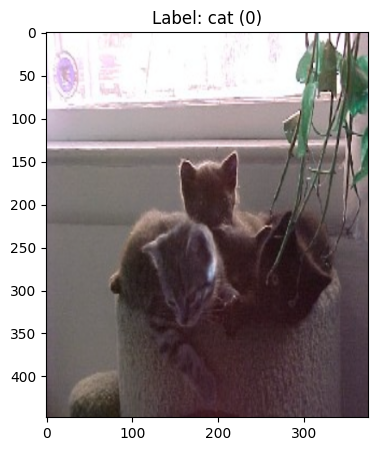

(448, 375, 3)


In [32]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(11)
idx = np.random.randint(0, len(dataset['train']))
sample_img, sample_label = dataset['train'][idx]

key = [k for k, v in classes.items() if v == sample_label][0]
fig = plt.figure(figsize=(5, 5))
img = sample_img.permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Unnormalize image
plt.imshow(img)
plt.title(f"Label: {key} ({sample_label})")
plt.show()
print(img.shape)

### Dataloaders

In [33]:
BS_train = 32
BS_test = 32

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_test, shuffle=False, num_workers=4),
}

In [34]:
batch_img, batch_label = next(iter(dataloader['train']))
print(batch_img.shape)

Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


torch.Size([32, 3, 448, 375])


In [35]:
batch_img, batch_label = next(iter(dataloader['val']))
print(batch_img.shape)

torch.Size([32, 3, 448, 375])


### Model

In [37]:
num_clases = len(classes)
num_clases

2

In [38]:
from torchvision.models import resnet50, ResNet50_Weights

model_freeze = resnet50(weights=ResNet50_Weights.DEFAULT)
for i, param in enumerate(model_freeze.parameters()):
    param.requires_grad = False
model_freeze.fc = torch.nn.Linear(model_freeze.fc.in_features, num_clases)

model_freeze.fc.out_features

2

Comprobamos que solo las últimas capas están descongeladas

In [39]:
for i, param in enumerate(model_freeze.parameters()):
    print(f"parameter {i}: type(param.data): {type(param.data)}, param.requires_grad: {param.requires_grad}")

parameter 0: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 1: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 2: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 3: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 4: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 5: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 6: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 7: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 8: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 9: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 10: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 11: type(param.data): <class 'torch.Tensor'>, param.requires_grad: False
parameter 12: 

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_freeze.to(device)
print("Using {} device".format(device))

Using cuda device


### Entrenamiento

In [41]:
LR = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_freeze.parameters(), lr=LR, weight_decay=1e-5)

In [7]:
num_prints = 2

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    mul = 1
    model.train()
    mean_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        preds = model(X)
        loss = loss_fn(preds, y)
        mean_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % int(len(dataloader)/num_prints) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            mul += 1
    
    return mean_loss/num_batches


def val_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            preds = model(X)
            val_loss += loss_fn(preds, y).item()
            # print(X.shape, preds.shape, preds.argmax(1), y)
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss, correct

In [43]:
epochs = 12
losses_train_freeze = []
losses_val_freeze = []
accuracies_val_freeze = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dataloader['train'], model_freeze, loss_fn, optimizer, device)
    losses_train_freeze.append(mean_loss)
    mean_loss, accuracy = val_loop(dataloader['val'], model_freeze, loss_fn, device)
    losses_val_freeze.append(mean_loss)
    accuracies_val_freeze.append(accuracy)
print("Done!")

Epoch 1
-------------------------------


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.141494  [ 9952/19956]


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.031956  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.5%, Avg loss: 0.062039 

Epoch 2
-------------------------------


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.031224  [ 9952/19956]


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.021752  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.8%, Avg loss: 0.043642 

Epoch 3
-------------------------------


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.064818  [ 9952/19956]


loss: 0.023918  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.8%, Avg loss: 0.038131 

Epoch 4
-------------------------------


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.121259  [ 9952/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


loss: 0.012805  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.7%, Avg loss: 0.035899 

Epoch 5
-------------------------------


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.037400  [ 9952/19956]


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.006752  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.7%, Avg loss: 0.035004 

Epoch 6
-------------------------------


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.058951  [ 9952/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.105374  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.9%, Avg loss: 0.030989 

Epoch 7
-------------------------------


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.002896  [ 9952/19956]


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.006371  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 99.0%, Avg loss: 0.028582 

Epoch 8
-------------------------------


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


loss: 0.045666  [ 9952/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.002014  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 99.0%, Avg loss: 0.028942 

Epoch 9
-------------------------------


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.026498  [ 9952/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.007157  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.7%, Avg loss: 0.032603 

Epoch 10
-------------------------------


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.019536  [ 9952/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


loss: 0.005100  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 99.0%, Avg loss: 0.027965 

Epoch 11
-------------------------------


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.014606  [ 9952/19956]


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.073808  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 99.0%, Avg loss: 0.028070 

Epoch 12
-------------------------------


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.067827  [ 9952/19956]


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.122761  [12460/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 97.8%, Avg loss: 0.051275 

Done!


Este entrenamiento en mi GPU me ha llevado unos 30 minutos

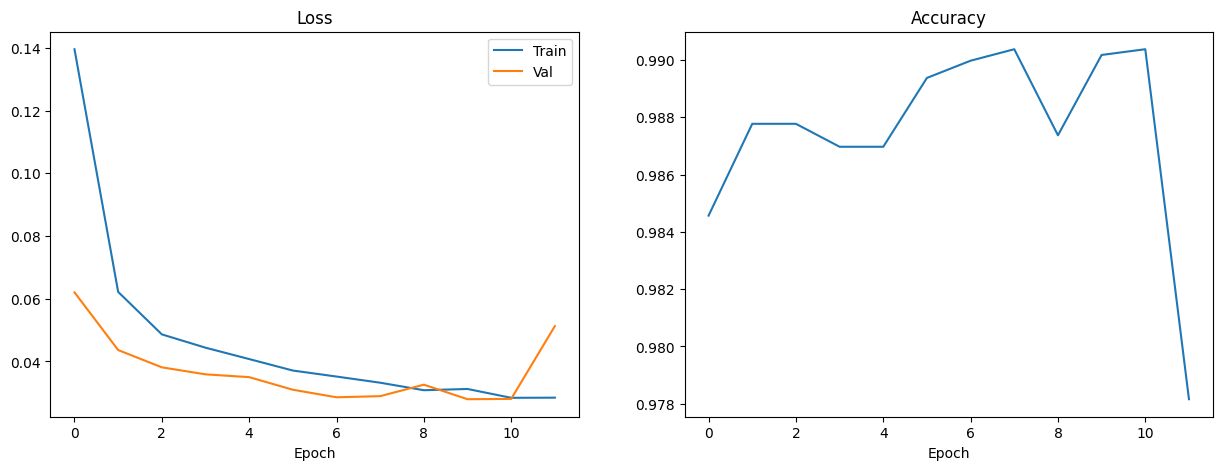

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses_train_freeze, label='Train')
ax[0].plot(losses_val_freeze, label='Val')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(accuracies_val_freeze)
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
plt.show()

Vamos a ver cómo se comporta con una imagen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


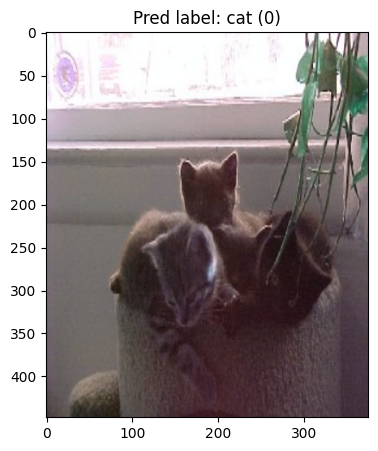

In [46]:
np.random.seed(11)
idx = np.random.randint(0, len(dataset['train']))
sample_img, sample_label = dataset['train'][idx]

pred = model_freeze(sample_img.unsqueeze(0).to(device))
pred = pred.argmax(1).item()
key = list(classes.keys())[list(classes.values()).index(pred)]

fig = plt.figure(figsize=(5, 5))
img = sample_img.permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Unnormalize image
plt.imshow(img)
plt.title(f"Pred label: {key} ({pred})")
plt.show()

## Ejemplo de entrenamiento con backbone descongelada

Para entrenar con una red descongelada nos vale el mismo dataset y dataloader, por lo que comenzamos a partir de crear el modelo

Primero libreamos la memoria de la GPU para poder seguir

In [55]:
import gc

del model_freeze
torch.cuda.empty_cache()
gc.collect()

0

Yo por si acaso reinicio el notebook para que se libere toda la memoria posible

Vuelvo a ejecutar todo lo necesario ya que al reiniciar se borran todas las variables. He tenido que bajar el tamaño de `BS`

In [1]:
import os
import pandas as pd
import cv2
import torch
import torchvision
from sklearn.model_selection import train_test_split
import numpy as np

df_cats = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Cat', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Cat')]})
df_cats['label'] = 0
df_cats['type'] = df_cats['path'].apply(lambda x: type(cv2.imread(x)))
df_cats = df_cats[df_cats.type != type(None)]

df_dogs = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Dog', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Dog')]})
df_dogs['label'] = 1
df_dogs['type'] = df_dogs['path'].apply(lambda x: type(cv2.imread(x)))
df_dogs = df_dogs[df_dogs.type != type(None)]

df = pd.concat([df_cats, df_dogs], axis=0).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)   # suffle df
df['height'] = df['path'].apply(lambda x: cv2.imread(x).shape[0])
df['width'] = df['path'].apply(lambda x: cv2.imread(x).shape[1])

median_shape = (int(df.height.median()), int(df.width.median()))
classes = {'cat': 0, 'dog': 1}
class DatasetCatsDogs(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.norm = torchvision.transforms.Normalize(self.mean, self.std)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx, 0])  # Read image
        if img.shape[0] != median_shape[0] or img.shape[1] != median_shape[1]:
            img = cv2.resize(img, median_shape) # Resize image
        img = torch.from_numpy(img).permute(2, 0, 1).float()    # Convert to tensor and permute dimensions
        img = img / 255.0  # Normalize image
        img = self.norm(img) # Standardize image
        label = self.df.loc[idx, 'label']
        return img, label

train_split, val_split = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])
# Reset index
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)
dataset = {
    'train': DatasetCatsDogs(train_split),
    'val': DatasetCatsDogs(val_split),
}

BS_train = 8
BS_test = 8
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_test, shuffle=False, num_workers=4),
}

num_clases = len(classes)
num_prints = 2

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    mul = 1
    model.train()
    mean_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        preds = model(X)
        loss = loss_fn(preds, y)
        mean_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % int(len(dataloader)/num_prints) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            mul += 1
    
    return mean_loss/num_batches

def val_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            preds = model(X)
            val_loss += loss_fn(preds, y).item()
            # print(X.shape, preds.shape, preds.argmax(1), y)
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss, correct

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 

### Model

In [2]:
from torchvision.models import resnet50, ResNet50_Weights

model_unfreeze = resnet50(weights=ResNet50_Weights.DEFAULT)
model_unfreeze.fc = torch.nn.Linear(model_unfreeze.fc.in_features, num_clases)

model_unfreeze.fc.out_features

2

Comprobamos que está la red entera descongelada

In [3]:
for i, param in enumerate(model_unfreeze.parameters()):
    print(f"parameter {i}: type(param.data): {type(param.data)}, param.requires_grad: {param.requires_grad}")

parameter 0: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 1: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 2: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 3: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 4: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 5: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 6: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 7: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 8: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 9: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 10: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 11: type(param.data): <class 'torch.Tensor'>, param.requires_grad: True
parameter 12: type(param.d

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_unfreeze.to(device)
print("Using {} device".format(device))

Using cuda device


### Entrenamiento

In [5]:
LR = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_unfreeze.parameters(), lr=LR, weight_decay=1e-5)

In [6]:
epochs = 12
losses_train_unfreeze = []
losses_val_unfreeze = []
accuracies_val_unfreeze = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dataloader['train'], model_unfreeze, loss_fn, optimizer, device)
    losses_train_unfreeze.append(mean_loss)
    mean_loss, accuracy = val_loop(dataloader['val'], model_unfreeze, loss_fn, device)
    losses_val_unfreeze.append(mean_loss)
    accuracies_val_unfreeze.append(accuracy)
print("Done!")

Epoch 1
-------------------------------


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


loss: 0.358287  [ 9968/19956]


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.140036  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 91.4%, Avg loss: 0.207019 

Epoch 2
-------------------------------


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.041668  [ 9968/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.559859  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 91.5%, Avg loss: 0.195866 

Epoch 3
-------------------------------


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.002624  [ 9968/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.803253  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 93.0%, Avg loss: 0.170536 

Epoch 4
-------------------------------


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.461697  [ 9968/19956]


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.038276  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 93.2%, Avg loss: 0.160385 

Epoch 5
-------------------------------


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.041720  [ 9968/19956]


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.131170  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.2%, Avg loss: 0.139753 

Epoch 6
-------------------------------


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.034350  [ 9968/19956]


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.249587  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.2%, Avg loss: 0.134741 

Epoch 7
-------------------------------


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.075978  [ 9968/19956]


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.003142  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.1%, Avg loss: 0.107873 

Epoch 8
-------------------------------


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.011991  [ 9968/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.073656  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 92.8%, Avg loss: 0.164174 

Epoch 9
-------------------------------


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.185741  [ 9968/19956]


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.081443  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.7%, Avg loss: 0.101686 

Epoch 10
-------------------------------


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


loss: 0.231015  [ 9968/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.010726  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.5%, Avg loss: 0.132380 

Epoch 11
-------------------------------


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.144515  [ 9968/19956]


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.004444  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.0%, Avg loss: 0.116172 

Epoch 12
-------------------------------


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.171977  [ 9968/19956]


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.028957  [19944/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.8%, Avg loss: 0.106891 

Done!


Este entrenamiento en mi GPU me ha llevado unos 75 minutos y ha consumido casi toda su memoria. Aquí se ve una diferecncia de tener el backbone congelado o descongelado, al tenerlo descongelado, el modelo entero ocupa más memoria de la GPU y el entrenamiento tarda más porque se tienen que hacer más operaciones

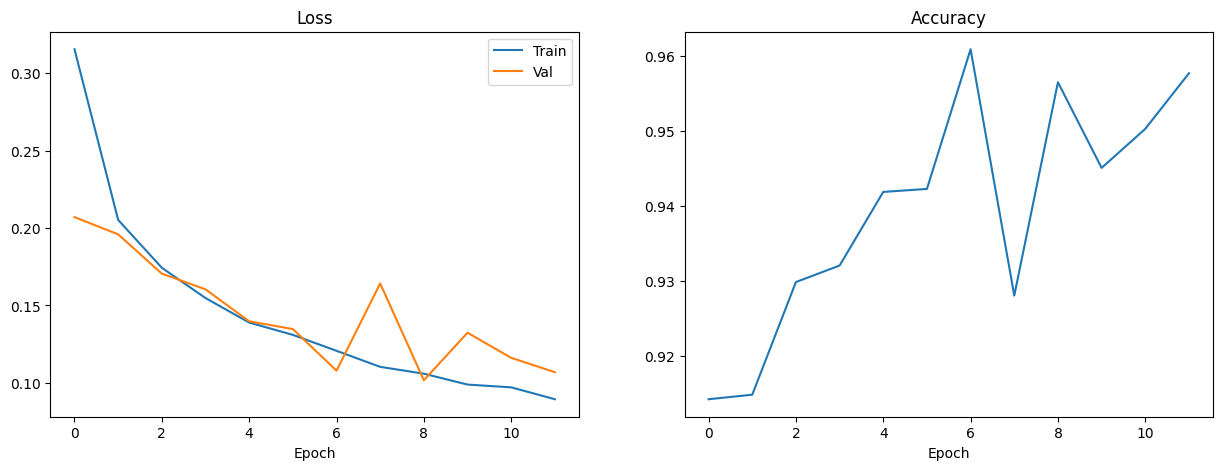

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses_train_unfreeze, label='Train')
ax[0].plot(losses_val_unfreeze, label='Val')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(accuracies_val_unfreeze)
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
plt.show()

Vamos a ver cómo se comporta con una imagen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


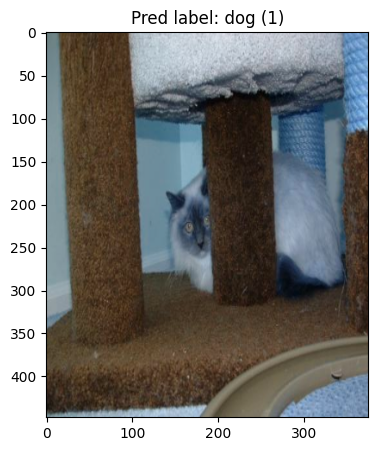

In [11]:
np.random.seed(11)
idx = np.random.randint(0, len(dataset['train']))
sample_img, sample_label = dataset['train'][idx]

pred = model_unfreeze(sample_img.unsqueeze(0).to(device))
pred = pred.argmax(1).item()
key = list(classes.keys())[list(classes.values()).index(pred)]

fig = plt.figure(figsize=(5, 5))
img = sample_img.permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Unnormalize image
plt.imshow(img)
plt.title(f"Pred label: {key} ({pred})")
plt.show()

## Entrenamiento en 2 fases

Una vez hemos visto la diferencia de entrenar con el backbone congelado o no, podemos ver una buena estrategia de entrenamiento, que es usar backbone congelado y no congelado.

Cuando nosotros cogemos un modelo preentrenado y le cambiamos la última capa, como hemos visto hasta ahora. En esta última capa perdemos los pesos del modelo preentrenado y lo que hace pytorch es crearla con pesos inicializados aleatoriamente. Por lo que una buena estrategia es entrenar el modelo unas pocas épocas con el backbone congelado, para que los pesos de la última capa tengan valores que más o menos hagan que la red funcione, y después se descongela el backbone y se entrena la red entera

Antes de nada vamos a liberar espacio en la memoria

In [39]:
import gc

del model_unfreeze
torch.cuda.empty_cache()
gc.collect()

469

Aunque yo por si acaso reinicio el notebook para que se libere toda la memoria posible

Vuelvo a ejecutar todo lo necesario ya que al reiniciar se borran todas las variables. Dejo el `BS` con el último valor, que lo he tenido que bajar

In [1]:
import os
import pandas as pd
import cv2
import torch
import torchvision
from sklearn.model_selection import train_test_split
import numpy as np

df_cats = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Cat', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Cat')]})
df_cats['label'] = 0
df_cats['type'] = df_cats['path'].apply(lambda x: type(cv2.imread(x)))
df_cats = df_cats[df_cats.type != type(None)]

df_dogs = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Dog', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Dog')]})
df_dogs['label'] = 1
df_dogs['type'] = df_dogs['path'].apply(lambda x: type(cv2.imread(x)))
df_dogs = df_dogs[df_dogs.type != type(None)]

df = pd.concat([df_cats, df_dogs], axis=0).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)   # suffle df
df['height'] = df['path'].apply(lambda x: cv2.imread(x).shape[0])
df['width'] = df['path'].apply(lambda x: cv2.imread(x).shape[1])

median_shape = (int(df.height.median()), int(df.width.median()))
classes = {'cat': 0, 'dog': 1}
class DatasetCatsDogs(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.norm = torchvision.transforms.Normalize(self.mean, self.std)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx, 0])  # Read image
        if img.shape[0] != median_shape[0] or img.shape[1] != median_shape[1]:
            img = cv2.resize(img, median_shape) # Resize image
        img = torch.from_numpy(img).permute(2, 0, 1).float()    # Convert to tensor and permute dimensions
        img = img / 255.0  # Normalize image
        img = self.norm(img) # Standardize image
        label = self.df.loc[idx, 'label']
        return img, label

train_split, val_split = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])
# Reset index
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)
dataset = {
    'train': DatasetCatsDogs(train_split),
    'val': DatasetCatsDogs(val_split),
}

BS_train = 8
BS_test = 8
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_test, shuffle=False, num_workers=4),
}

num_clases = len(classes)
num_prints = 2

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    mul = 1
    model.train()
    mean_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        preds = model(X)
        loss = loss_fn(preds, y)
        mean_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % int(len(dataloader)/num_prints) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            mul += 1
    
    return mean_loss/num_batches

def val_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            preds = model(X)
            val_loss += loss_fn(preds, y).item()
            # print(X.shape, preds.shape, preds.argmax(1), y)
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss, correct

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

### Model - backbone freeze

Creamos el modelo y congelamos el bakbone

In [2]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)
for i, param in enumerate(model.parameters()):
    param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, num_clases)

model.fc.out_features

2

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Using {} device".format(device))

Using cuda device


### Entrenamiento

Entrenamos solo 5 épocas para que la última capa tenga pesos que hagan que la red funciona más o menos bien

In [4]:
LR = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [5]:
epochs = 5
losses_train_freeze = []
losses_val_freeze = []
accuracies_val_freeze = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dataloader['train'], model, loss_fn, optimizer, device)
    losses_train_freeze.append(mean_loss)
    mean_loss, accuracy = val_loop(dataloader['val'], model, loss_fn, device)
    losses_val_freeze.append(mean_loss)
    accuracies_val_freeze.append(accuracy)
print("Done!")

Epoch 1
-------------------------------


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


loss: 0.113125  [ 9968/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.070694  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.5%, Avg loss: 0.043979 

Epoch 2
-------------------------------


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.020332  [ 9968/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


loss: 0.244097  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.5%, Avg loss: 0.036685 

Epoch 3
-------------------------------


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.185692  [ 9968/19956]


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


loss: 0.004837  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.3%, Avg loss: 0.045798 

Epoch 4
-------------------------------


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.021206  [ 9968/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.004531  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.7%, Avg loss: 0.037348 

Epoch 5
-------------------------------


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.024516  [ 9968/19956]


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.015567  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 98.5%, Avg loss: 0.039539 

Done!


Al igual que antes, al tener el backbone congelado, el entrenamiento ha tardado en mi GPU solo una media hora. Ahora eran solo 5 épocas, no 12 como antes

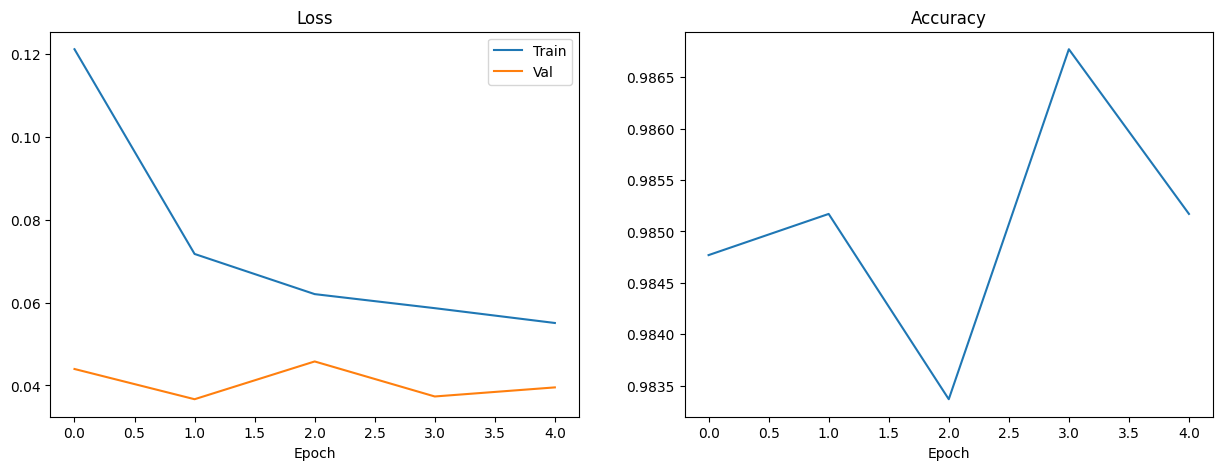

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses_train_freeze, label='Train')
ax[0].plot(losses_val_freeze, label='Val')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(accuracies_val_freeze)
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
plt.show()

### Model - backbone unfreeze

Ahora descongelamos el backbone del modelo

In [9]:
import gc

torch.cuda.empty_cache()
gc.collect()

721

In [10]:
for i, param in enumerate(model.parameters()):
    param.requires_grad = True

### Entrenamiento

Entrenamos todo el modelo 12 épocas

In [11]:
LR = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [12]:
epochs = 12
losses_train = []
losses_val = []
accuracies_val = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dataloader['train'], model, loss_fn, optimizer, device)
    losses_train.append(mean_loss)
    mean_loss, accuracy = val_loop(dataloader['val'], model, loss_fn, device)
    losses_val.append(mean_loss)
    accuracies_val.append(accuracy)
print("Done!")

Epoch 1
-------------------------------


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.348623  [ 9968/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


loss: 0.172329  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 89.6%, Avg loss: 0.233796 

Epoch 2
-------------------------------


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.288834  [ 9968/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


loss: 0.072154  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 92.0%, Avg loss: 0.189093 

Epoch 3
-------------------------------


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.228601  [ 9968/19956]


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


loss: 0.172792  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 93.3%, Avg loss: 0.158829 

Epoch 4
-------------------------------


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.235458  [ 9968/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


loss: 0.039593  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 93.2%, Avg loss: 0.153826 

Epoch 5
-------------------------------


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


loss: 0.016989  [ 9968/19956]


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.082513  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.1%, Avg loss: 0.150373 

Epoch 6
-------------------------------


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.054974  [ 9968/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.083958  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 93.8%, Avg loss: 0.147804 

Epoch 7
-------------------------------


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.084279  [ 9968/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.171092  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.1%, Avg loss: 0.142029 

Epoch 8
-------------------------------


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.172881  [ 9968/19956]


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.012490  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.2%, Avg loss: 0.138809 

Epoch 9
-------------------------------


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.059295  [ 9968/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.109397  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.1%, Avg loss: 0.116943 

Epoch 10
-------------------------------


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.133712  [ 9968/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.011988  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.6%, Avg loss: 0.111990 

Epoch 11
-------------------------------


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.010465  [ 9968/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.255828  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 93.5%, Avg loss: 0.169544 

Epoch 12
-------------------------------


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.043729  [ 9968/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


loss: 0.024702  [19944/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.8%, Avg loss: 0.145180 

Done!


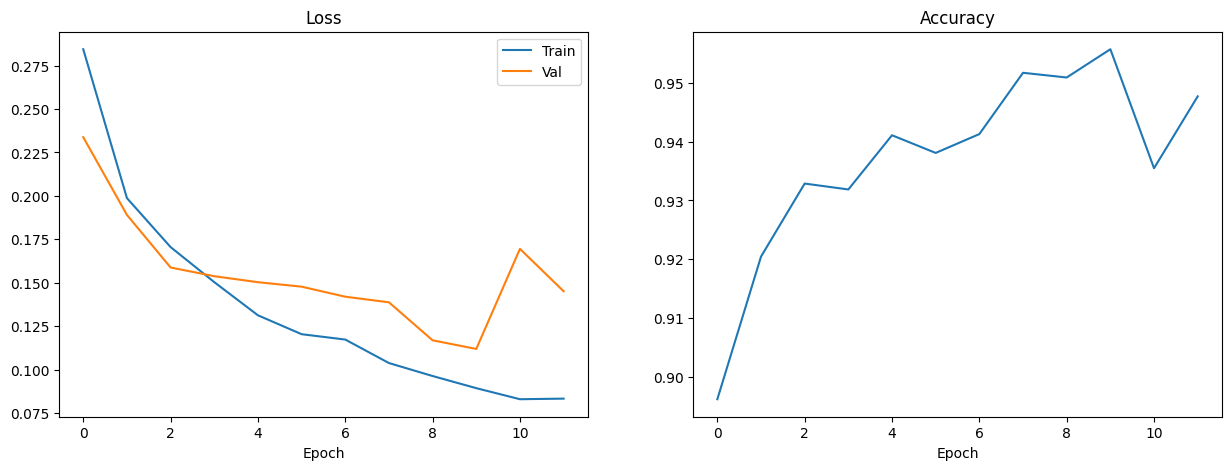

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses_train, label='Train')
ax[0].plot(losses_val, label='Val')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(accuracies_val)
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
plt.show()

Entrenando la red de esta forma se deberían tener mejores resultados que solo congelando o no congelando el backbone. Aunque en este caso no ha sido así porque como una red preentreada en imagenet ya sabe distinguir entre perros y gatos, además de otros objetos, es mejor entrenar solo la última capa y no tocar el backbone. Pero por ejemplo, si se usa transfer learning para reconocer lunares malignos, eso no lo sabe hacer una red preentrenada en imagenet, por lo que ahí si tiene más sentido hacer lo que acabamos de hacer